In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/crab-age-prediction/CrabAgePrediction.csv
/kaggle/input/playground-series-s3e16/sample_submission.csv
/kaggle/input/playground-series-s3e16/train.csv
/kaggle/input/playground-series-s3e16/test.csv


In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import FunctionTransformer

from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor as cbr
from lightgbm import LGBMRegressor as lgbmr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

from sklearn.model_selection import KFold
from scipy.stats import uniform, loguniform, randint
from sklearn.metrics import mean_absolute_error

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e16/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e16/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s3e16/sample_submission.csv')
#add = pd.read_csv('/kaggle/input/crab-age-prediction/CrabAgePrediction.csv')

In [4]:
#train = pd.concat([train1, add])

In [5]:
def summary(df):
    print(f'data shape: {df.shape}')  
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    
    return summ

summary(train)

data shape: (74051, 10)


,data type,#missing,%missing,#unique,min,max
id,int64,0,0.0,74051,0.0,74050.0
Sex,object,0,0.0,3,NaN,NaN
Length,float64,0,0.0,144,0.1875,2.012815
Diameter,float64,0,0.0,122,0.1375,1.6125
Height,float64,0,0.0,65,0.0,2.825
Weight,float64,0,0.0,3096,0.056699,80.101512
Shucked Weight,float64,0,0.0,1766,0.028349,42.184056
Viscera Weight,float64,0,0.0,967,0.042524,21.54562
Shell Weight,float64,0,0.0,1048,0.042524,28.491248
Age,int64,0,0.0,28,1.0,29.0


In [6]:
category_cols = train.columns[1]
numeric_cols = train.columns[2:9].tolist()
all_columns = [category_cols] + numeric_cols
target = "Age"

In [7]:
df_original = train.copy(deep = True)
train = df_original

X = train[all_columns].copy(deep = True)
y = train[target].copy(deep = True)

X_test = test[all_columns].copy(deep = True)

In [8]:
X.duplicated().sum(), X_test.duplicated().sum()

(0, 0)

In [9]:
print("Before:", np.sort(X["Height"].unique())[:2], np.sort(X_test["Height"].unique())[:2])
second_smallest = np.sort(X["Height"].unique())[1]
X.loc[X["Height"] < second_smallest, "Height"] = second_smallest
X_test.loc[X_test["Height"] < second_smallest, "Height"] = second_smallest

print("After adjustment:",np.sort(X["Height"].unique())[:2], np.sort(X_test["Height"].unique())[:2])

Before: [0.     0.0125] [0.    0.025]
After adjustment: [0.0125 0.025 ] [0.0125 0.025 ]


In [10]:
X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

In [11]:
def feat_engineering(input_df):
    temp_df = input_df.copy(deep = True)
    
    temp_df["BMI"] = temp_df["Weight"]/(temp_df["Height"] * temp_df["Height"])
    temp_df["Body_Volume"] = temp_df["Diameter"] * temp_df["Height"] * temp_df["Length"]
    temp_df["Body_Density"] = temp_df["Weight"] / temp_df["Body_Volume"]
    
    temp_df["Shell_Area_Density"] = temp_df["Shell Weight"] / (temp_df["Length"] * temp_df["Diameter"])
    temp_df["Shell_Mass_Index"] = temp_df["Shell Weight"] / (temp_df["Length"] * temp_df["Diameter"]) ** 2
    
    temp_df["Ratio_Shucked_Weight"] = temp_df["Shucked Weight"] / temp_df["Weight"]
    temp_df["Ratio_Shell_Weight"] = temp_df["Shell Weight"] / temp_df["Weight"]
    temp_df["Ratio_Viscera_Weight"] = temp_df["Viscera Weight"] / temp_df["Weight"]
    
    return temp_df

In [12]:
X_feat = feat_engineering(X)
X_test_feat = feat_engineering(X_test)

In [13]:
for col in X_feat:
    X_feat.loc[:,col] = winsorize(X_feat[col], (0.02, 0.02))
    X_test_feat.loc[:,col] = winsorize(X_test_feat[col], (0.02, 0.02))

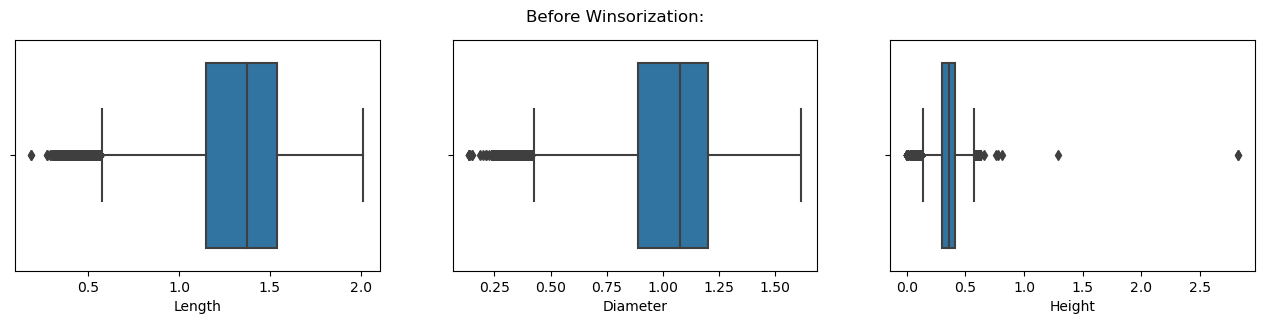

In [14]:
fig, axes = plt.subplots(1, 3, figsize = (16,3))
fig.suptitle('Before Winsorization:')
for start, i in enumerate(train.columns[2:5]):
    sns.boxplot(data = train, x = i, ax = axes[start%3])
plt.show()

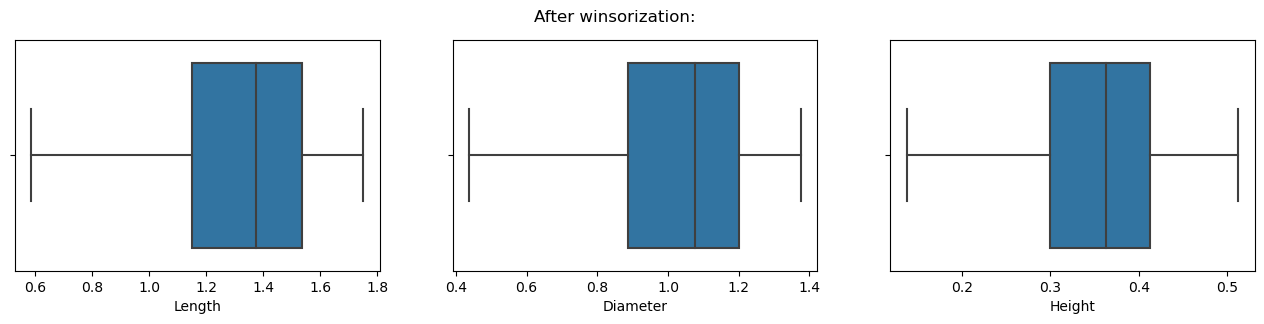

In [15]:
fig, axes = plt.subplots(1, 3, figsize = (16,3))
fig.suptitle('After winsorization:')
for start, i in enumerate(X_feat.columns[:3]):
    sns.boxplot(data = X_feat, x = i, ax = axes[start%3])
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.07, random_state=42)
print(X_train.shape, X_test.shape)

(68867, 18) (5184, 18)


In [17]:
xgbr = XGBRegressor()
xgbr.fit(X_train,y_train)
xgbr_pred = xgbr.predict(X_test)
print("MAE :", mean_absolute_error(y_test,xgbr_pred))

MAE : 1.4247962376217784


In [18]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

model_grid = XGBRegressor(n_estimators=330 , 
                          learning_rate=0.01 ,
                          max_depth=7)

model_grid.fit(X_train, y_train)
y_pred_xgb_grid_sub = model_grid.predict(X_test)

mae_xgb_grid = mean_absolute_error(y_test, [i+0.001 if i == 10 else round(i) for i in y_pred_xgb_grid_sub])
mae_xgb_grid

1.3539737654320987

In [19]:
model_grid = XGBRegressor(n_estimators=330 , 
                          learning_rate=0.01 ,
                          max_depth=7)
model_grid.fit(X_train, y_train)
y_pred_xgb_grid_sub = model_grid.predict(X_test_feat)
y_pred_xgb_grid_sub

array([ 7.381752,  7.642722, 10.281422, ..., 12.699353,  9.688964,
       11.181508], dtype=float32)

In [20]:
sub['Age'] = [round(i) for i in y_pred_xgb_grid_sub]
sub

,id,Age
0,74051,7
1,74052,8
2,74053,10
3,74054,9
4,74055,7
...,...,...
49363,123414,9
49364,123415,8
49365,123416,13
49366,123417,10


In [21]:
sub.to_csv("submission15.csv" , index=False)

In [22]:
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_absolute_error
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid to search over
# param_grid = {
#     'n_estimators': [300, 500],
#     'learning_rate': [0.01, 0.1],
#     'max_depth': [5, 7, 9]
# }

# # Create an XGBoost regressor
# model = XGBRegressor()

# # Create the GridSearchCV object
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error')

# # Fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # Get the best model
# best_model = grid_search.best_estimator_

# # Make predictions on the test data using the best model
# y_pred = best_model.predict(X_test)

# # Calculate mean absolute error
# mae = mean_absolute_error(y_test, [i + 0.001 if i == 10 else round(i) for i in y_pred])

# # Print the best parameters and the resulting mean absolute error
# print("Best parameters:", grid_search.best_params_)
# print("Mean Absolute Error:", mae)